# More Estimation

> ベルギーの 1 ユーロ硬貨を 250 回指ではじいて回してみたところ、表が 140 回、裏が 110 回出た。
ロンドン・スクール・オブ・エコノミクス（ LSE ）の統計学の講師である Barry Bright は、「非常に怪しい」「硬貨に偏りがないなら、このような極端な結果の出る確率は 7% より小さい」と語っている。

この問題は本当に正しいことを言っているのか

In [5]:
import thinkbayes
import thinkplot
from thinkbayes import Suite
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

In [6]:
def print_suite(suite):
    X = [];Y = []
    for x,y in suite.Items():
        X.append(x)
        Y.append(y)

    plt.plot(X,Y)

### 4.1 ユーロ硬貨問題

In [7]:
# H_x が、 x の値 0 から 100 についての、表の出る確率が x%であるという101個の仮説を立てる
# 一様仮説
class Euro(Suite):

    def Likelihood(self, data, hypo):
        x = hypo
        if data == 'H':
            return x/100.0
        else:
            return 1 - x/100.0

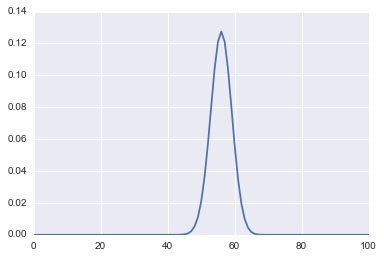

In [8]:
# Test
suite = Euro(xrange(0, 101))
dataset = 'H' * 140 + 'T' * 110
for data in dataset:
    suite.Update(data)

print_suite(suite)

### 4.2 事後確率を求める

#### 方式1　事後確率分布において最もあり得る値を返す

#### 方式1の実装
すでに実装してある
```python
def MaximumLikelihood(pmf):
    """Returns the value with the highest probability."""
    prob, val = max((prob, val) for val, prob in pmf.Items())
    return val
```

In [9]:
print "Maximum likehood", suite.MaximumLikelihood()
print 'Mean', suite.Mean()
print 'Median', thinkbayes.Percentile(suite, 50)
print 'CI', thinkbayes.CredibleInterval(suite, 90)

Maximum likehood 56
Mean 55.9523809524
Median 56
CI (51, 61)


ユーロ硬貨問題を解くには、xが50%になる確率を求めればいい？

In [10]:
print suite.Prob(50)

0.0209765261295


"101個の仮説を立てたときの値"でしかなく、領域を多くしたり少なくすれば値が変わってしまうため、この値には意味がない。

### 4.3 事前確率を圧倒する

実際のところ、コインの表裏が偏る確率は10%や90%になることはない
なので、一様確率という仮定がよくない

そこで、事前確率を50%に近いxの値については高い確率を、極端な値については低い確率を与えるようなものとする。

三角事前確率を用いる

In [11]:
def TrianglePrior():
    suite = Euro()
    for x in range(0, 51):
        suite.Set(x, x)

    for x in range(51, 101):
        suite.Set(x, 100-x)
    suite.Normalize()
    return suite


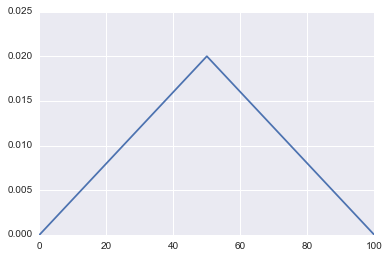

In [12]:
suite_t = TrianglePrior()
print_suite(suite_t)

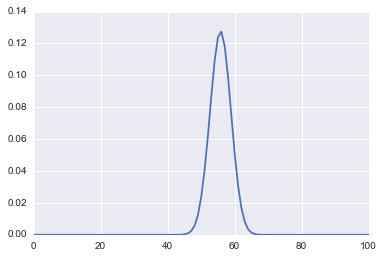

In [13]:
dataset = 'H' * 140 + 'T' * 110
for data in dataset:
    suite_t.Update(data)

print_suite(suite_t)

In [14]:
print "Maximum likehood", suite_t.MaximumLikelihood()
print 'Mean', suite_t.Mean()
print 'Median', thinkbayes.Percentile(suite_t, 50)
print 'CI', thinkbayes.CredibleInterval(suite_t, 90)

Maximum likehood 56
Mean 55.7434994386
Median 56
CI (51, 61)


In [15]:
print "Maximum likehood", suite_t.MaximumLikelihood(), suite.MaximumLikelihood()
print 'Mean', suite_t.Mean(), suite.Mean()
print 'Median', thinkbayes.Percentile(suite_t, 50), thinkbayes.Percentile(suite, 50)
print 'CI', thinkbayes.CredibleInterval(suite_t, 90),thinkbayes.CredibleInterval(suite, 90),

Maximum likehood 56 56
Mean 55.7434994386 55.9523809524
Median 56 56
CI (51, 61) (51, 61)


ほぼ一緒

### 4.4最適化

こでまでのコードを最適化してみよう

これまでのコード

```python
dataset = 'H' * heads + 'T' * tails
for data in dataset:
    suite.Update(data)

# Update
def Update(self, data):
    for hypo in self.Values():
        like = self.Likelihood(data, hypo)
        self.Mult(hypo, like)
    return self.Normalize()
```

毎回仮説を一つずつ処理して、正規化を行っていた。
しかし、すべて反映させてから正規化して返した方が、早い

Suite には、それを行う UpdateSet というメソッドがある。

```python
def UpdateSet(self, dataset):
    for data in dataset:
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
    return self.Normalize()
```

つまり、
```python
dataset = 'H' * heads + 'T' * tails
suite.UpdateSet(dataset)
```
だけでよい

しかしオーダーは試行回数nによって、左右されたままである。
すべての試行データを一度に処理するにはどうすればいいか。

→データ集合を2つの整数、表の個数と裏の個数の組としてコード化

```python
# class Euro():
def Likelihood(self, data, hypo):
    x = hypo / 100.0
    heads, tails = data
    like = x**heads * (1-x)**tails
    return like
```

こうすることで、
```python
heads, tails = 140, 110
suite.Update((heads, tails))
```

このように処理できるようになる。

### 4.5 ベータ分布

さらに高速化するために、ベータ分布が使える

二項尤度関数でベイズ更新を行うとき、ベータ分布は共役事前確率
→ xの事前確率がベータ分布であるなら、事後確率もベータ分布

> ベータ分布の形は、 2 つのパラメータ、 α と β 、すわなち alpha と beta とに依存する。
事前確率が、パラメータ alpha と beta を持つベータ分布であり、表が h 、裏が t のデー
タであったとすれば、事後確率は、パラメータが alpha+h と beta+t を持つベータ分布
となる。言い換えると、更新を 2 つの加算だけで行うことができる。

ベータ分布を表すクラス`Beta`が存在
デフォルトで、一様分布を作成し、`Update(data)`はベイズ更新を行う
`Beta`には、確率密度関数を計算する`EvalPdf(x)`も存在する。

よって新しい方法は下記の通りに表される。

In [16]:
beta = thinkbayes.Beta()
beta.Update((140, 110))
print beta.Mean()

0.559523809524


### 4.6 議論

同じ問題で、ことなる事前確率をとったとしてもデータ集号が十分大きければ同じ値に収束する

しかし、常にそうなるわけではない。
ベイズ分析がモデル化の決定に依存する

ベイズ更新において、事前確率に尤度をかけることに注意
（Ex. Dによらず、p(H)が0ならp(H|D)も0に

→クロムウェル規則
たとえあり得ないと思っても、どの仮説にも確立0を割り当てるべきではない


### 4.7 練習問題

#### 問題1

硬貨投げを直接観察する代わりに、計測装置を使って結果を測定するが、計測装置
には間違いがあるものとする。具体的には、実際は表なのに裏であるという結果が報
告されたり、実際は裏なのに表と報告される確率が y だとする。
一連の結果と y の値から、硬貨の偏りを推定するクラスを書け。
事後確率分布の広がり方は、 y にどの程度依存するか

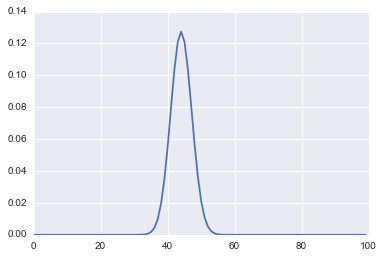

In [45]:
from ipywidgets import interact
import numpy as np

# ここは自分で埋めて欲しい
@interact(y=(0,1,.1))
def f(y):
    class Euro(Suite):
        def Likelihood(self, data, hypo):
            x = hypo
            if data == 'H':
                return x/100.0 * (1 - y) + y * (1 - x/100.0) 
            else:
                return (1 - x/100.0) * (1-y) + y* x/100.0

    dataset = "H" * 140 + "T" * 110
    suite = Euro(range(0,100))
    suite.UpdateSet(dataset)


    print_suite(suite)

    


#### 問題2

Reddit とは、 subreddit （板）と呼ばれる多くの専門グループからなるオンラインフォー
ラムである。利用者は redditor と呼ばれ、オンラインの内容へのリンクやウェブページ
を投稿する。他の redditor が、そのリンクについて投票して、高品質なリンクには、賛
成票（ upvote ）を、よくなかったり無関係なリンクについては、反対票（ downvote ）を投
じる。
Dominosci が投じた問題とは、 redditor の中には信頼できる人と信頼できない人がい
るのだが、 Reddit では、それを考慮していないということである。
課題は、 redditor が投票するときに、その redditor の信頼度に応じてリンクの品質の
推測値が更新され、また redditor の信頼度の推測値がリンクの品質に応じて更新され
るようなシステムを作り出すことである。
1 つのやり方は、リンクの品質を賛成票を生成する確率としてモデル化し、 redditor
の信頼度を高品質なものに対して賛成票を正しく投じる確率としてモデル化することである。
Redditor とリンクに対するクラス定義と、 redditor が投票するたびに両方のオブジェ
クトを更新する更新関数を書け。

In [13]:
# ここは自分で埋めて欲しい